Model trained on contaxts being original_code. 

In [1]:
from transformers import (
    BartTokenizerFast,
    DataCollatorForSeq2Seq,
    keras_callbacks,
    TFAutoModelForSeq2SeqLM,
)
import tensorflow as tf
from datasets import Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from huggingface_hub import notebook_login
from datasets import concatenate_datasets
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, generative_qa_utils
from question_answering.paths import generative_qa_paths
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback

In [2]:
df_train, df_val, df_test = core_qa_utils.load_datasets_from_csv(
    generative_qa_paths.python_dataset_dir
)

df_train = pd.concat([df_train, df_val], ignore_index=True)

train_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_test]
)

In [3]:
model_checkpoint = "facebook/bart-base"
tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-base")

In [4]:
def tokenize_sample(sample, max_tokens=None, padding=False):
    question = sample["questions"].strip()
    context = sample["original_code"].strip()

    return tokenizer(question, context, max_length=max_tokens, padding=padding)

tokenized_train_dataset = train_dataset.map(tokenize_sample)
tokenized_test_dataset = test_dataset.map(tokenize_sample)

print(
    "Max number of tokens in tokenized train dataset: ",
    len(max(tokenized_train_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized test dataset: ",
    len(max(tokenized_test_dataset["input_ids"], key=len)),
)

Map:   0%|          | 0/63080 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1490 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Max number of tokens in tokenized train dataset:  9244
Max number of tokens in tokenized test dataset:  901


In [5]:
max_length = 256


def filter_samples_below_number_of_tokens(dataset, max_tokens: int):
    indices_to_remove = []

    # Find indices of samples where number of tokens exceeds max number of tokens
    for index, sample in enumerate(dataset):
        tokenized_sample = tokenize_sample(sample)
        if len(tokenized_sample["input_ids"]) > max_tokens:
            indices_to_remove.append(index)

    # Keep only samples with number of tokens less or equal than max number of tokens
    dataset_indices = range(len(dataset))
    filtered_dataset = dataset.select(
        index for index in dataset_indices if index not in set(indices_to_remove)
    )

    return filtered_dataset


filtered_train_dataset = filter_samples_below_number_of_tokens(
    train_dataset, max_tokens=max_length
)
filtered_test_dataset = filter_samples_below_number_of_tokens(
    test_dataset, max_tokens=max_length
)

Parameter 'indices'=<generator object filter_samples_below_number_of_tokens.<locals>.<genexpr> at 0x000001DBA6EBAF10> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
print(
    "Number of samples in tokenized train dataset before filtering: ",
    len(train_dataset),
)
print(
    "Number of samples in tokenized test dataset before filtering: ", len(test_dataset)
)

print("\n---------------\n")

print(
    "Number of samples in tokenized train dataset after filtering: ",
    len(filtered_train_dataset),
)
print(
    "Number of samples in tokenized test dataset after filtering: ",
    len(filtered_test_dataset),
)

Number of samples in tokenized train dataset before filtering:  63080
Number of samples in tokenized test dataset before filtering:  2500

---------------

Number of samples in tokenized train dataset after filtering:  61758
Number of samples in tokenized test dataset after filtering:  2450


In [7]:
def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["questions"]]
    contexts = [c.strip() for c in dataset["original_code"]]
    answers = [c.strip() for c in dataset["answers"]]

    inputs = tokenizer(
        questions,
        contexts,
        text_target=answers,
        max_length=max_length,
        truncation=True
    )

    return inputs

In [8]:
tokenized_train_dataset = filtered_train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_train_dataset.column_names,
)
tokenized_test_dataset = filtered_test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_test_dataset.column_names,
)

Map:   0%|          | 0/61758 [00:00<?, ? examples/s]

Map:   0%|          | 0/2450 [00:00<?, ? examples/s]

In [9]:
# Model parameters
training_number = 2

model_name = "python-bart-original"
full_model_name = f"{model_name}-{training_number}"

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
    generative_qa_paths.training_checkpoints_dir
    / full_model_name
    / checkpoint_filename_template
)

# Hub
hub_path = generative_qa_paths.hub_models_location / full_model_name

# Saved models
saved_models_path = generative_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = generative_qa_paths.model_evaluation_dir / full_model_name

# Hyperparameters
batch_size = 8
train_epochs = 5

In [10]:
# Load model for fine-tuning
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForConditionalGeneration: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
- This IS expected if you are initializing TFBartForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [11]:
# Dataset preparation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

tf_train_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_train_dataset,
    collator=data_collator,
    batch_size=batch_size,
    shuffle=True
)

tf_test_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_test_dataset,
    collator=data_collator,
    batch_size=batch_size,
)

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
# push_to_hub = keras_callbacks.PushToHubCallback(
#     output_dir=full_model_name, tokenizer=tokenizer
# )

time_measure_cb = TimeMeasureCallback()

callbacks = [
    checkpoint_cb,
    # push_to_hub,
    time_measure_cb
]

In [13]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
model.compile(optimizer=optimizer)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


In [14]:
model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLaye  multiple                 50265     
 r)                                                              
                                                                 
Total params: 139,470,681
Trainable params: 139,420,416
Non-trainable params: 50,265
_________________________________________________________________


In [15]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/5
7719/7719 [==============================] - ETA: 0s - loss: 2.9181
Epoch 1: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-original-2\cp-01.ckpt
7719/7719 [==============================] - 3402s 437ms/step - loss: 2.9181
Epoch 2/5
7719/7719 [==============================] - ETA: 0s - loss: 2.1753
Epoch 2: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-original-2\cp-02.ckpt
7719/7719 [==============================] - 5203s 674ms/step - loss: 2.1753
Epoch 3/5
7719/7719 [==============================] - ETA: 0s - loss: 1.7290
Epoch 3: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-original-2\cp-03.ckpt
7719/7719 [==============================] - 1044s 135ms/step - loss: 1.7290
Epoch 4/5
7719/7719 [==============================] - ETA: 0s - loss: 1.3962
Epoch 4: saving model to e:\STUDIA\IPS\question-answering\generative-qa\trai

In [16]:
# Get best version of the model
best_model, best_epoch = core_qa_utils.get_best_model_from_checkpoints(
    model, history, model_name=full_model_name, metric="loss", remove_checkpoints=True, model_type="generative"
)

In [17]:
# Save best model's weights
generative_qa_utils.save_model(best_model, model_name=full_model_name)

In [18]:
loaded_weights_model = generative_qa_utils.load_weights_into_model(
    model=model, 
    model_name=full_model_name
)

In [19]:
# Get predictions from the best model
loaded_model_evaluation = loaded_weights_model.evaluate(tf_test_dataset)

307/307 [==============================] - 25s 59ms/step - loss: 2.7600


In [20]:
parts_number = 100

test_dataset_pandas = tokenized_test_dataset.to_pandas()
test_dataset_array = np.array_split(test_dataset_pandas, parts_number)

test_datasets_list = []

for row in tqdm(test_dataset_array):
    test_datasets_list.append(core_qa_utils.prepare_tf_dataset(
        model=model,
        hf_dataset=Dataset.from_pandas(row),
        collator=data_collator,
        batch_size=batch_size,
))

c:\Users\Artur\.conda\envs\question_answering\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


In [24]:
# questions_and_answers_df = pd.DataFrame()
index_to_start_from = 79
predictions_list = []
labels_list = []
question_contexts_list = []

i = 0
for dataset in tqdm(test_datasets_list):
    if i < index_to_start_from:
        i = i + 1
        continue
    for batch, labels in tqdm(dataset):
        predictions = generative_qa_utils.generate_predictions(model, batch, max_length)
        decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = labels
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_predictions = [prediction.strip() for prediction in decoded_predictions]
        decoded_labels = [label.strip() for label in decoded_labels]
        predictions_list.extend(decoded_predictions)
        labels_list.extend(decoded_labels)
        question_contexts_list.extend(tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True))

        data = {
            'question_contexts': tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True),
            'labels': decoded_labels,
            'predictions': decoded_predictions
        }
        questions_and_answers_df = pd.concat([questions_and_answers_df, pd.DataFrame(data)], ignore_index=True)
    i = i + 1

100%|██████████| 100/100 [25:36<00:00, 15.36s/it]


In [25]:
dataset_dataframe_with_predictions = generative_qa_utils.split_questions_and_contexts_into_two_columns(dataframe=questions_and_answers_df)
dataset_dataframe_with_predictions

,questions,contexts,labels,predictions
0,How does the code add a user in the given buck...,def add_bucket_default_owner bucket_name user_...,as an owner,with the given name
1,Does the code add a user in the given buckets ...,def add_bucket_default_owner bucket_name user_...,Yes,Yes
2,Where does the code add a user as an owner?,def add_bucket_default_owner bucket_name user_...,in the given buckets default object access con...,in a bucket
3,Does the code create a simple sdist tarball at...,def make_trivial_sdist dist_path setup_py setu...,Yes,Yes
4,How does the code create a simple sdist tarball?,def make_trivial_sdist dist_path setup_py setu...,at dist_path,with the given setup and pyfile
...,...,...,...,...
2445,What do the sequence contain?,def all_bases_valid seq valid_bases ['a' 'A' '...,only bases,only valid base names
2446,What created this variable?,def get_brick var return get_annotation var Brick,the brick,the brick
2447,What does the code retrieve?,def get_brick var return get_annotation var Brick,the brick that created this variable,the brick
2448,What does approximate joint diagonalization im...,def test_ajd n_times n_channels 10 3 seed np r...,same results as the matlab implementation by p...,the correct type of array


In [26]:
bleu_result, rogue_result, meteor_result= generative_qa_utils.get_metrics(dataset_dataframe_with_predictions)
print(
    "BLEU:\n",
    bleu_result,
    "\nROGUE:\n",
    rogue_result,
    "\nMETEOR:\n",
    meteor_result
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU:
 {'bleu': 0.08833380884857235, 'precisions': [0.41565358342016906, 0.16486180701470826, 0.09537642217380779, 0.0634314100114635], 'brevity_penalty': 0.6190528293491558, 'length_ratio': 0.675874481571328, 'translation_length': 8637, 'reference_length': 12779} 
ROGUE:
 {'rouge1': 0.3523572077542042, 'rouge2': 0.111032204284911, 'rougeL': 0.3433873579159352, 'rougeLsum': 0.3434038802553442} 
METEOR:
 {'meteor': 0.23500724047949628}


In [27]:
closed_questions_dictionary = generative_qa_utils.get_closed_questions_split_according_to_answer_correctness(dataframe=dataset_dataframe_with_predictions)

number_of_closed_questions = len(closed_questions_dictionary['closed_all'])
number_of_correct_answers = len(closed_questions_dictionary['closed_correct_answer'])
number_of_wrong_answers = len(closed_questions_dictionary['closed_wrong_answer'])

number_of_long_answers_for_closed_questions = len(closed_questions_dictionary['closed_long_answer'])

print("Correct answers: ", number_of_correct_answers)
print("Wrong answers: ", number_of_wrong_answers)
print("Long answers for closed questions: ", number_of_long_answers_for_closed_questions)
print("Wrong answers without the long ones: ", number_of_wrong_answers - number_of_long_answers_for_closed_questions)

Correct answers:  105
Wrong answers:  30
Long answers for closed questions:  0
Wrong answers without the long ones:  30


In [28]:
# Save all relevant training and evaluation metrics to a json file.
evaluation_data = {
    "training": {
        "metrics": history.history,
        "attempted_epochs": train_epochs,
        "best_epoch": best_epoch,
        "training_time": time_measure_cb.total_training_time(),
        "gpu": core_qa_utils.get_gpu_name(),
    },
    "test_set": {
        "loss": loaded_model_evaluation,
        "bleu": bleu_result,
        "rogue": rogue_result,
        "meteor": meteor_result,
        "closed_questions": {
            "closed_questions_number": number_of_closed_questions,
            "correct_answers_number": number_of_correct_answers,
            "wrong_answers_number": number_of_wrong_answers,
            "long_answers_for_closed_questions_number": number_of_long_answers_for_closed_questions,
        }
    },
}

core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

In [29]:
dataset_dataframe_with_predictions = generative_qa_utils.calculate_bleus_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_rouges_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_meteor_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions

2450it [00:51, 47.51it/s]
2450it [22:11,  1.84it/s]
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2450it [00:26, 91.48it/s]


,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,How does the code add a user in the given buck...,def add_bucket_default_owner bucket_name user_...,as an owner,with the given name,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,Does the code add a user in the given buckets ...,def add_bucket_default_owner bucket_name user_...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.000000,1.000000,0.500000
2,Where does the code add a user as an owner?,def add_bucket_default_owner bucket_name user_...,in the given buckets default object access con...,in a bucket,0.0,0.333333,0.0,0.166667,0.000000,0.166667,0.119048
3,Does the code create a simple sdist tarball at...,def make_trivial_sdist dist_path setup_py setu...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.000000,1.000000,0.500000
4,How does the code create a simple sdist tarball?,def make_trivial_sdist dist_path setup_py setu...,at dist_path,with the given setup and pyfile,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2445,What do the sequence contain?,def all_bases_valid seq valid_bases ['a' 'A' '...,only bases,only valid base names,0.0,0.250000,0.0,0.333333,0.000000,0.333333,0.454545
2446,What created this variable?,def get_brick var return get_annotation var Brick,the brick,the brick,0.0,1.000000,1.0,1.000000,1.000000,1.000000,0.937500
2447,What does the code retrieve?,def get_brick var return get_annotation var Brick,the brick that created this variable,the brick,0.0,1.000000,1.0,0.500000,0.333333,0.500000,0.334821
2448,What does approximate joint diagonalization im...,def test_ajd n_times n_channels 10 3 seed np r...,same results as the matlab implementation by p...,the correct type of array,0.0,0.200000,0.0,0.133333,0.000000,0.133333,0.048077


In [30]:
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
prediction_counts_per_metric_range = generative_qa_utils.calculate_prediction_counts_per_metric_range(dataset_dataframe_with_predictions, thresholds)
prediction_counts_per_metric_range

{'bleu': [2381, 20, 12, 11, 26],
 'bleu1': [856, 416, 410, 288, 480],
 'bleu2': [1956, 140, 141, 54, 159],
 'rouge1': [916, 625, 389, 261, 259],
 'rouge2': [1955, 242, 113, 49, 91],
 'rougeL': [942, 647, 371, 239, 251],
 'meteor': [1437, 453, 300, 135, 125]}

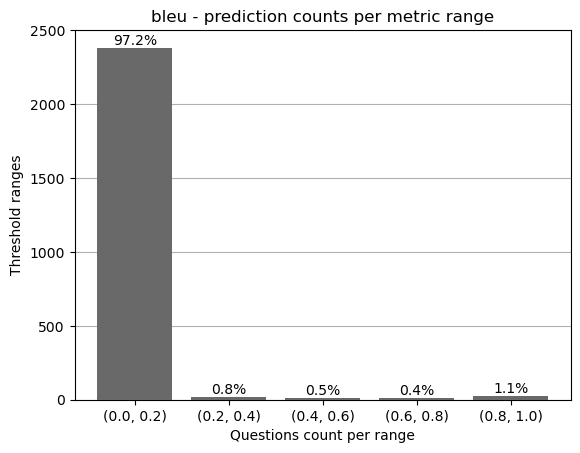

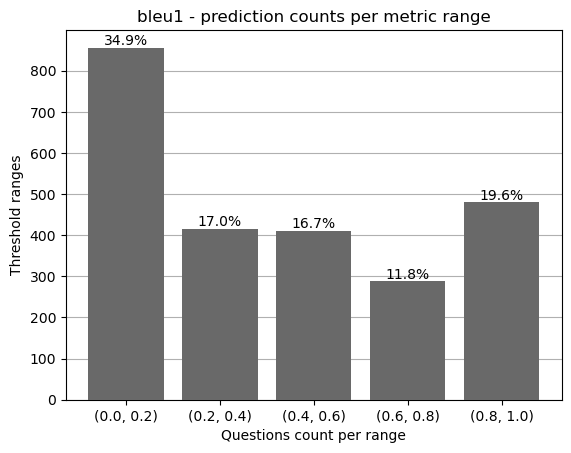

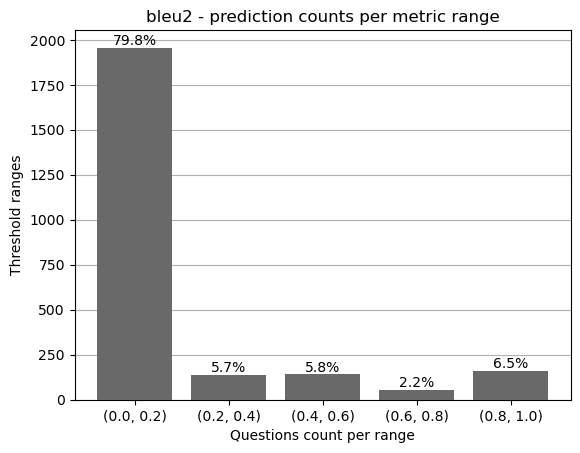

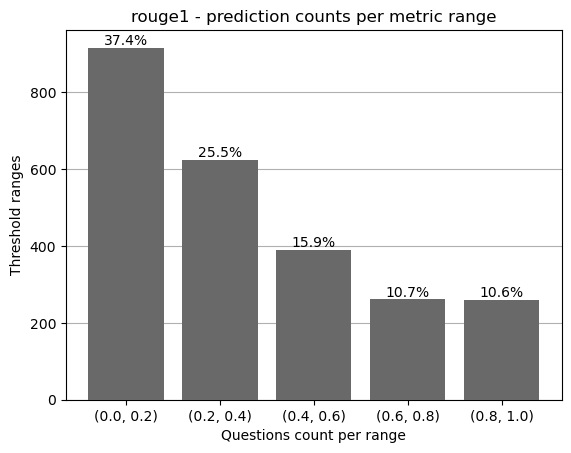

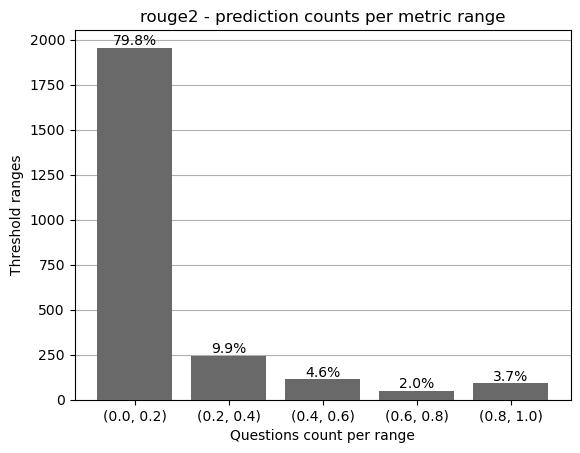

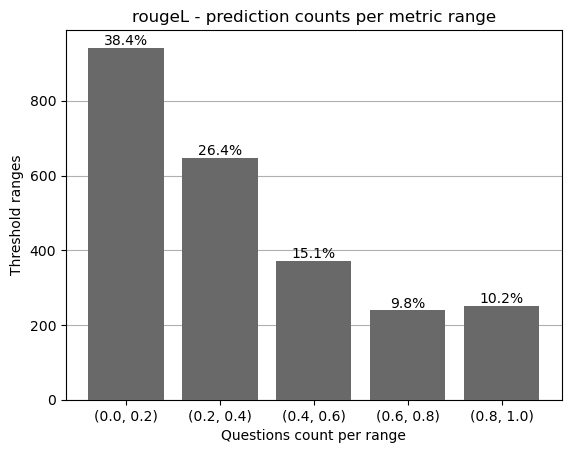

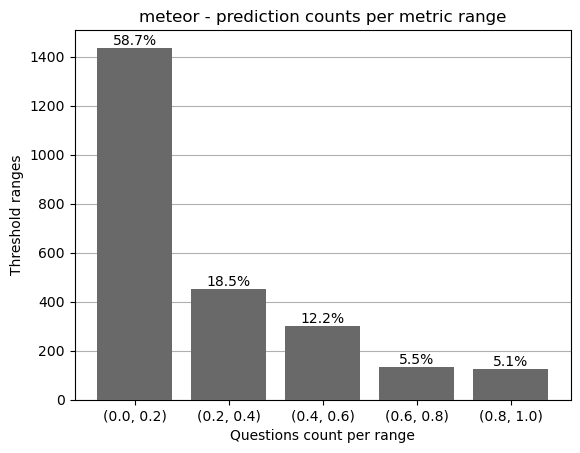

In [31]:
generative_qa_utils.plot_prediction_counts_per_metric_range_diagrams(
    prediction_counts_per_metric = prediction_counts_per_metric_range,
    thresholds=thresholds,
    figure_directory_path=model_evaluation_dir
    )

In [32]:
dataset_dataframe_with_predictions.to_csv(
    model_evaluation_dir / "test_set_sample_generation.csv", index=True, index_label="index"
)

In [33]:
dataset_dataframe_with_predictions = pd.read_csv(model_evaluation_dir / "test_set_sample_generation.csv")
dataset_dataframe_with_predictions

,index,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,0,How does the code add a user in the given buck...,def add_bucket_default_owner bucket_name user_...,as an owner,with the given name,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,1,Does the code add a user in the given buckets ...,def add_bucket_default_owner bucket_name user_...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.000000,1.000000,0.500000
2,2,Where does the code add a user as an owner?,def add_bucket_default_owner bucket_name user_...,in the given buckets default object access con...,in a bucket,0.0,0.333333,0.0,0.166667,0.000000,0.166667,0.119048
3,3,Does the code create a simple sdist tarball at...,def make_trivial_sdist dist_path setup_py setu...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.000000,1.000000,0.500000
4,4,How does the code create a simple sdist tarball?,def make_trivial_sdist dist_path setup_py setu...,at dist_path,with the given setup and pyfile,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2445,2445,What do the sequence contain?,def all_bases_valid seq valid_bases ['a' 'A' '...,only bases,only valid base names,0.0,0.250000,0.0,0.333333,0.000000,0.333333,0.454545
2446,2446,What created this variable?,def get_brick var return get_annotation var Brick,the brick,the brick,0.0,1.000000,1.0,1.000000,1.000000,1.000000,0.937500
2447,2447,What does the code retrieve?,def get_brick var return get_annotation var Brick,the brick that created this variable,the brick,0.0,1.000000,1.0,0.500000,0.333333,0.500000,0.334821
2448,2448,What does approximate joint diagonalization im...,def test_ajd n_times n_channels 10 3 seed np r...,same results as the matlab implementation by p...,the correct type of array,0.0,0.200000,0.0,0.133333,0.000000,0.133333,0.048077


In [34]:
dataframe_predictions_and_question_types = generative_qa_utils.add_question_types_to_dataset_dataframe(dataset_predictions_dataframe=dataset_dataframe_with_predictions)

In [35]:
only_metric_columns_dataframe = dataframe_predictions_and_question_types[['bleu', 'bleu1', 'bleu2', 'rouge1', 'rouge2', 'rougeL', 'meteor', 'question_type']]
metric_mean_values_dataframe = only_metric_columns_dataframe.groupby(['question_type']).mean()
metric_mean_values_dataframe.insert(
    loc=0,
    column='question_type',
    value=list(only_metric_columns_dataframe.groupby(['question_type']).groups.keys())
)
metric_mean_values_dataframe.to_csv(
    model_evaluation_dir / "metric_mean_values.csv", index=False
)
metric_mean_values_dataframe

,question_type,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
question_type,,,,,,,,
closed,closed,0.000000,0.777778,0.000000,0.777778,0.000000,0.777778,0.388889
for_whats,for_whats,0.004582,0.342291,0.129524,0.268658,0.099085,0.264456,0.174068
hows,hows,0.006904,0.178920,0.047896,0.151068,0.038601,0.151068,0.102138
others,others,0.000000,0.424330,0.143103,0.369419,0.133224,0.362522,0.273446
whats,whats,0.023586,0.434692,0.150424,0.348935,0.125859,0.336506,0.240470
whens,whens,0.000000,0.267338,0.107362,0.235997,0.096654,0.235997,0.158432
wheres,wheres,0.012601,0.429098,0.167486,0.389203,0.140789,0.387564,0.276468


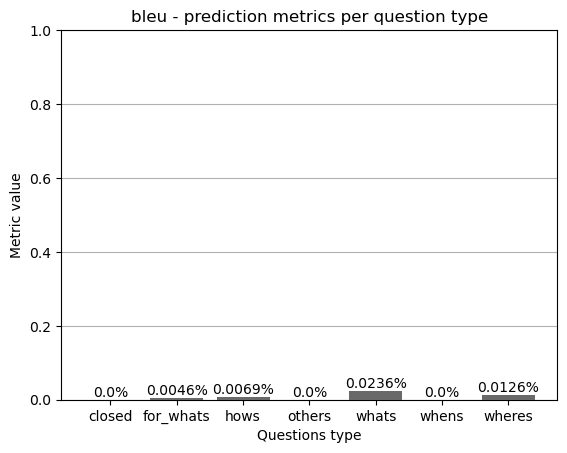

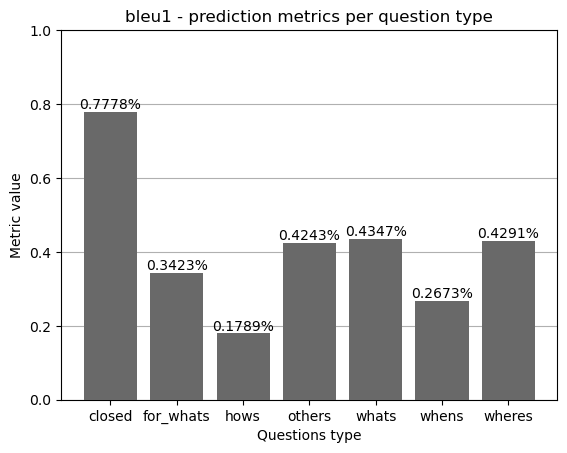

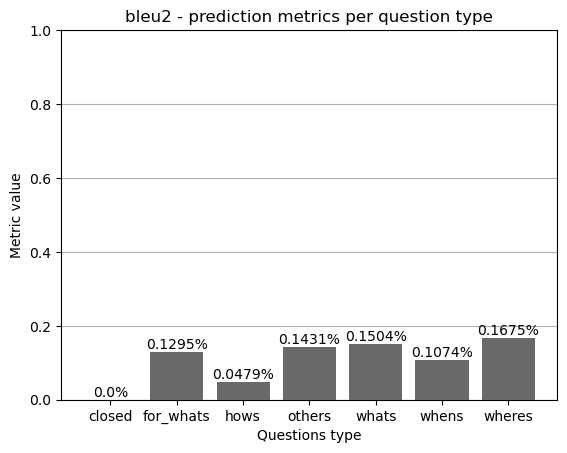

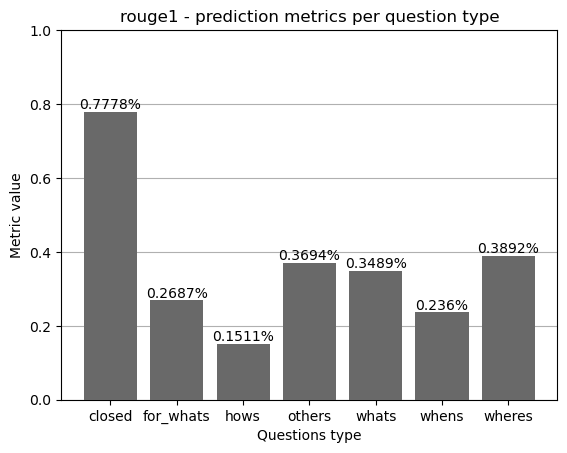

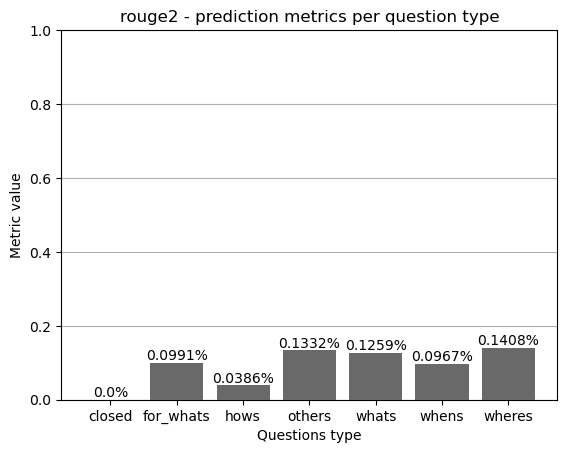

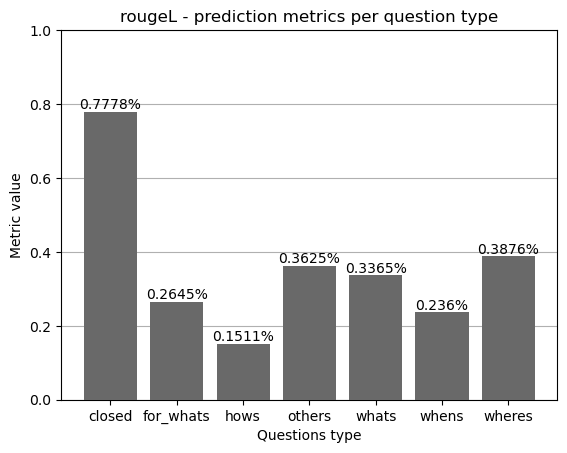

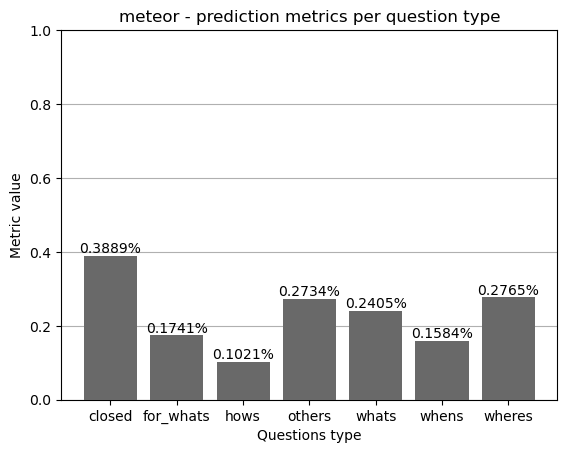

In [36]:
generative_qa_utils.plot_prediction_metrics_per_question_type_diagram(
    metric_mean_values_dataframe=metric_mean_values_dataframe,
    figure_directory_path=model_evaluation_dir / 'figures' / 'metrics-per-type'
)

In [37]:
question_type_metrics_dictionary = generative_qa_utils.count_prediction_numbers_per_metric_range_for_specific_question_type(dataframe_predictions_and_question_types)
generative_qa_utils.save_question_type_metrics_dictionary_to_csv(model_evaluation_dir=model_evaluation_dir, question_type_metrics_dictionary=question_type_metrics_dictionary)
question_type_metrics_dictionary = generative_qa_utils.read_question_type_metrics_dictionary_from_csv(model_evaluation_dir=model_evaluation_dir)
question_type_metrics_dictionary

{'whats':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)  1749    575   1410     626    1415     651    1057
 1      1  (0.2, 0.4)    18    333    103     516     185     537     381
 2      2  (0.4, 0.6)    11    335    121     331      88     315     163
 3      3  (0.6, 0.8)    11    243     37     209      44     187     103
 4      4  (0.8, 1.0)    24    327    142     131      81     123     109,
 'wheres':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)   120     32     85      34      87      34      65
 1      1  (0.2, 0.4)     0     30     14      35      23      36      26
 2      2  (0.4, 0.6)     1     24     12      24       6      23      10
 3      3  (0.6, 0.8)     0     19      4      17       1      17      12
 4      4  (0.8, 1.0)     1     17      7      12       5      12       9,
 'hows':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0

In [38]:
generative_qa_utils.plot_prediction_counts_per_metric_range_per_question_type_diagram(
    question_type_metrics_dictionary=question_type_metrics_dictionary,
    figure_directory_path=model_evaluation_dir / 'figures' / 'counts-per-metric-range'
)